In [1]:
import pandas as pd     
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn

## 1 Load Data

In [2]:
# read train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# use to index the submittion file
PassengerId = test['PassengerId']

# process train and test dataset at the same time
all_data = pd.concat([train, test], ignore_index = True)

## 2 Analyse Data

### 2.1 overview

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2.2 the relationships between every features and survival

In [5]:
# the number of survival and death
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

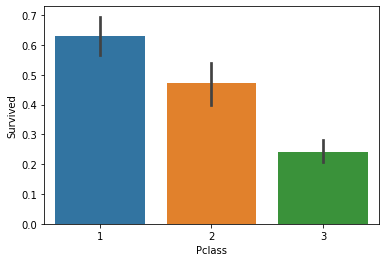

In [6]:
# Pclass：the higher the class, the higher the survival rate
sns.barplot(x = 'Pclass', y = 'Survived', data = train)

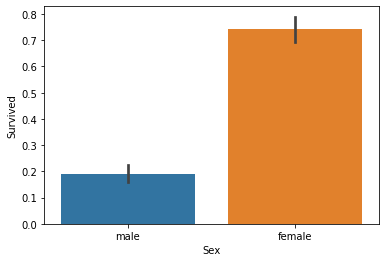

In [7]:
# Sex：female is more likely to survive than male
sns.barplot(x = 'Sex', y = 'Survived', data = train)

Text(12.359751157407416, 0.5, 'density')

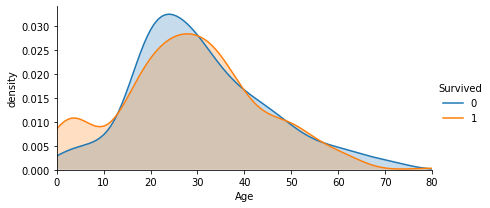

In [8]:
# Age：under 15-year-old there is an apparent differency of survival rate in the same age
facet = sns.FacetGrid(train, hue = 'Survived', aspect = 2)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(Xlim = (0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age')
plt.ylabel('density')

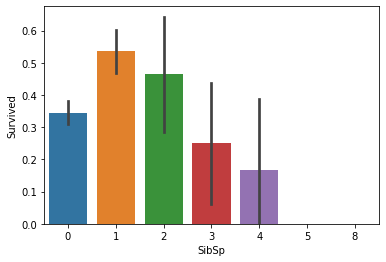

In [9]:
# SibSp：the more medium the number of sublings, the higher survival rate
sns.barplot(x = 'SibSp', y = 'Survived', data = train)

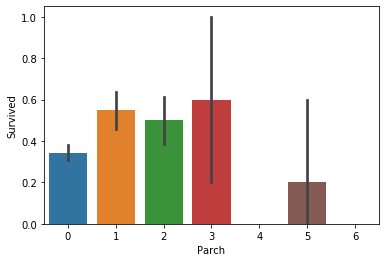

In [10]:
# Parch：the more medium the number of parents and children, the higher survival rate
sns.barplot(x = 'Parch', y = 'Survived', data = train)

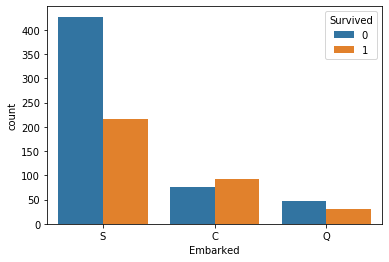

In [11]:
# Embarked：C has the highest survival rate
sns.countplot('Embarked', hue = 'Survived', data = train)

### 2.3 create new features with name, family and ticket

In [12]:
# surname
all_data['Surname'] = all_data['Name'].apply(lambda x : x.split(',')[0].strip())

In [13]:
# Name Title
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master', 'Jonkheer'], 'Master'))

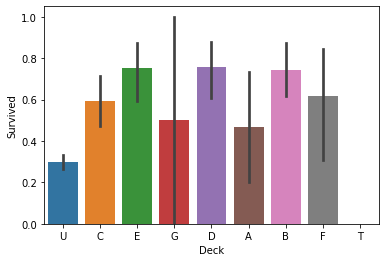

In [14]:
# show the deck using cabin number
# E D B is more likely to survive
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)
sns.barplot(x = 'Deck', y = 'Survived', data = all_data)

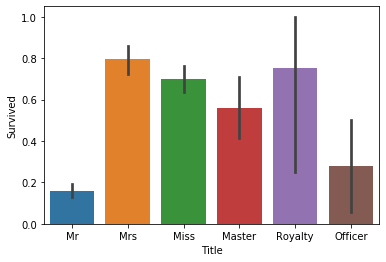

In [15]:
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x = 'Title', y = 'Survived', data = all_data)

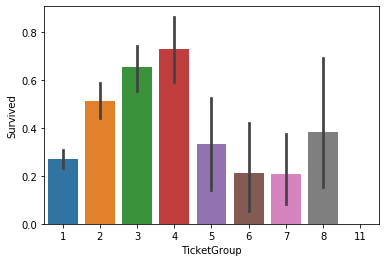

In [16]:
# TicketGroup
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x : Ticket_Count[x])
sns.barplot(x = 'TicketGroup', y = 'Survived', data = all_data)

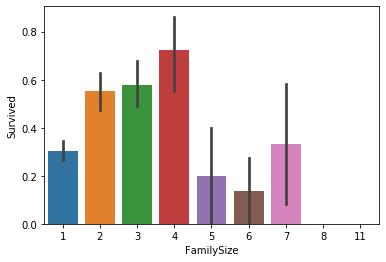

In [17]:
# FamilySize
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x = 'FamilySize', y = 'Survived', data = all_data)

## 3 Clean Data

### 3.1 fill missing values

In [18]:
# Age：the missing rate of Age is quite high, so use random forest to fill it based on Sex, Title and Pclass
all_data[all_data['Age'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize
5,NaN,Unknown,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,Moran,Mr,U,1,1
17,NaN,Unknown,S,13.0000,"Williams, Mr. Charles Eugene",0,18,2,male,0,1.0,244373,Williams,Mr,U,1,1
19,NaN,Unknown,C,7.2250,"Masselmani, Mrs. Fatima",0,20,3,female,0,1.0,2649,Masselmani,Mrs,U,1,1
26,NaN,Unknown,C,7.2250,"Emir, Mr. Farred Chehab",0,27,3,male,0,0.0,2631,Emir,Mr,U,1,1
28,NaN,Unknown,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,female,0,1.0,330959,O'Dwyer,Miss,U,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,NaN,Unknown,Q,7.7208,"Riordan, Miss. Johanna Hannah""""",0,1300,3,female,0,NaN,334915,Riordan,Miss,U,1,1
1301,NaN,Unknown,Q,7.7500,"Naughton, Miss. Hannah",0,1302,3,female,0,NaN,365237,Naughton,Miss,U,1,1
1304,NaN,Unknown,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,Spector,Mr,U,1,1
1307,NaN,Unknown,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Ware,Mr,U,1,1


In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
age_df = all_data[['Age', 'Pclass', 'Sex', 'Title']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1:])
all_data.loc[(all_data.Age.isnull()), 'Age'] = predictedAges

In [21]:
all_data[all_data['Age'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize


In [22]:
# Embarked：only two missing values, and set to C according to Pclass，Embarked
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Icard,Miss,B,2,1
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Stone,Mrs,B,2,1


In [23]:
all_data.groupby(by = ['Pclass', 'Embarked']).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [24]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [25]:
# Fare：there is only one missing value, and calculate the median value of fare according to Embarked and Pclass
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Storey,Mr,U,1,1


In [26]:
fare = all_data[(all_data['Embarked'] == 'S') & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

In [27]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize


### 3.2 identity the same groups

In [28]:
# # group the people who have the same surname
# all_data['Surname'] = all_data['Name'].apply(lambda x : x.split(',')[0].strip())
# Surname_Count = dict(all_data['Surname'].value_counts())
# all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x : Surname_Count[x])

# # group (children and female) and (adult male)
# Female_Child_Group = all_data.loc[(all_data['FamilyGroup'] >= 2) & ((all_data['Age'] <= 12) | (all_data['Sex'] == 'female'))]
# Male_Adult_Group = all_data.loc[(all_data['FamilyGroup'] >= 2) & (all_data['Age'] > 12) & (all_data['Sex'] == 'male')]

In [29]:
# # the children and female in the same group were all survived or all died
# Female_Child = pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
# Female_Child.columns = ['GroupCount']
# Female_Child

In [30]:
# sns.barplot(x=Female_Child.index, y=Female_Child['GroupCount']).set_xlabel('AverageSurvived')

In [31]:
# # adult male is the same as the (children and female) group 
# Male_Adult = pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
# Male_Adult.columns = ['GroupCount']
# Male_Adult

In [32]:
# # 因为普遍是妇女儿童生存率高，成年男性生存率低。所以我们把反常的姓氏提取出来
# Female_Child_Group = Female_Child_Group.groupby('Surname')['Survived'].mean()
# Dead_List = set(Female_Child_Group[Female_Child_Group.apply(lambda x : x == 0)].index)
# print(Dead_List)

# Male_Adult_List = Male_Adult_Group.groupby('Surname')['Survived'].mean()
# Survived_List = set(Male_Adult_List[Male_Adult_List.apply(lambda x : x == 1)].index)
# print(Survived_List)

In [33]:
# # 使反常组中的Age，Title，Sex进行惩罚修改
# train = all_data.loc[all_data['Survived'].notnull()]
# test = all_data.loc[all_data['Survived'].isnull()]
# test.loc[(test['Surname'].apply(lambda x : x in Dead_List)), 'Sex'] = 'male'
# test.loc[(test['Surname'].apply(lambda x : x in Dead_List)), 'Age'] = 60
# test.loc[(test['Surname'].apply(lambda x : x in Dead_List)), 'Title'] = 'Mr'
# test.loc[(test['Surname'].apply(lambda x : x in Survived_List)), 'Sex'] = 'female'
# test.loc[(test['Surname'].apply(lambda x : x in Survived_List)), 'Age'] = 5
# test.loc[(test['Surname'].apply(lambda x : x in Survived_List)), 'Title'] = 'Miss'

### 3.3 特征转换

In [34]:
# 选取特征，转换为数值变量，划分训练集和测试集
all_data = all_data[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Surname', 'Title', 'Deck', 'FamilySize', 'TicketGroup']]
all_data = pd.get_dummies(all_data)
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()].drop('Survived', axis = 1)
X = train.as_matrix()[:, 1:]
y = train.as_matrix()[:, 0]

## 4 Build and Optimize Model

### 4.1 参数优化：网格化搜索自动选取最优参数

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

In [36]:
pipe = Pipeline([('select', SelectKBest(k = 20)), 
                ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])
param_test = {'classify__n_estimators' : list(range(20, 50, 2)),
                'classify__max_depth' : list(range(3, 60, 3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring = 'roc_auc', cv = 10)
gsearch.fit(X, y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 9, 'classify__n_estimators': 40} 0.8695929887106357


### 4.2 训练模型

In [37]:
from sklearn.pipeline import make_pipeline

In [45]:
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True,
                            n_estimators = 40,
                            max_depth = 9,
                            max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_classif at 0x00000238E79D0E58>)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=40, n_jobs=None,
                                        oob_score=False, random_state=10,
                                        verbose=0, war

### 4.3 Cross validation

In [46]:
from sklearn import metrics
from sklearn import model_selection

In [47]:
cv_score = model_selection.cross_val_score(pipeline, X, y, cv = 10)
print("CV Score : Mean - %.7g | Std - %7g" % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.827166 | Std - 0.0396002


## 5 Predict Data

In [48]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({'PassengerId' : PassengerId, 'Survived' : predictions.astype(np.int32)})
submission.to_csv(r"submission1.csv", index = False)